In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import rasterio

import os
from tqdm.notebook import tqdm_notebook as tqdm
from joblib import delayed, Parallel

import albumentations as A

from src.utils import tqdm_joblib

In [2]:
train_df = pd.read_csv('splits/Train.csv')
test_df = pd.read_csv('splits/Test.csv')

In [3]:
train_df.head()

image_id                        bbox  category_id      id
0  id_w55q2qr62fsk    [122.0, 1.0, 42.0, 30.0]          2.0  6356.0
1  id_fvldv7o1kn9d  [500.0, 141.0, 74.0, 70.0]          2.0  2305.0
2  id_5d1r9l1jp7b5  [304.0, 525.0, 54.0, 58.0]          2.0   238.0
3  id_45qru79t6s4n  [187.0, 298.0, 44.0, 56.0]          2.0   921.0
4  id_84cjf2pbqmtv  [349.0, 721.0, 58.0, 59.0]          2.0  1362.0

In [4]:
test_df.head()

image_id
0  id_uawi0k5spci5
1  id_ba566jv4xzln
2  id_q4odggcgnc77
3  id_4lrqmvmmgier
4  id_sqadni8gqzao

In [5]:
submission = pd.read_csv('SampleSubmission.csv')
submission.head()

image_id  Target
0  id_uawi0k5spci5_1       0
1  id_uawi0k5spci5_2       0
2  id_uawi0k5spci5_3       0
3  id_ba566jv4xzln_1       0
4  id_ba566jv4xzln_2       0

In [6]:
train_df.shape

(26156, 4)

In [7]:
np.unique(train_df.image_id).shape

(4772,)

/trinity/home/georgy.popandopulo/.conda/envs/spectral/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


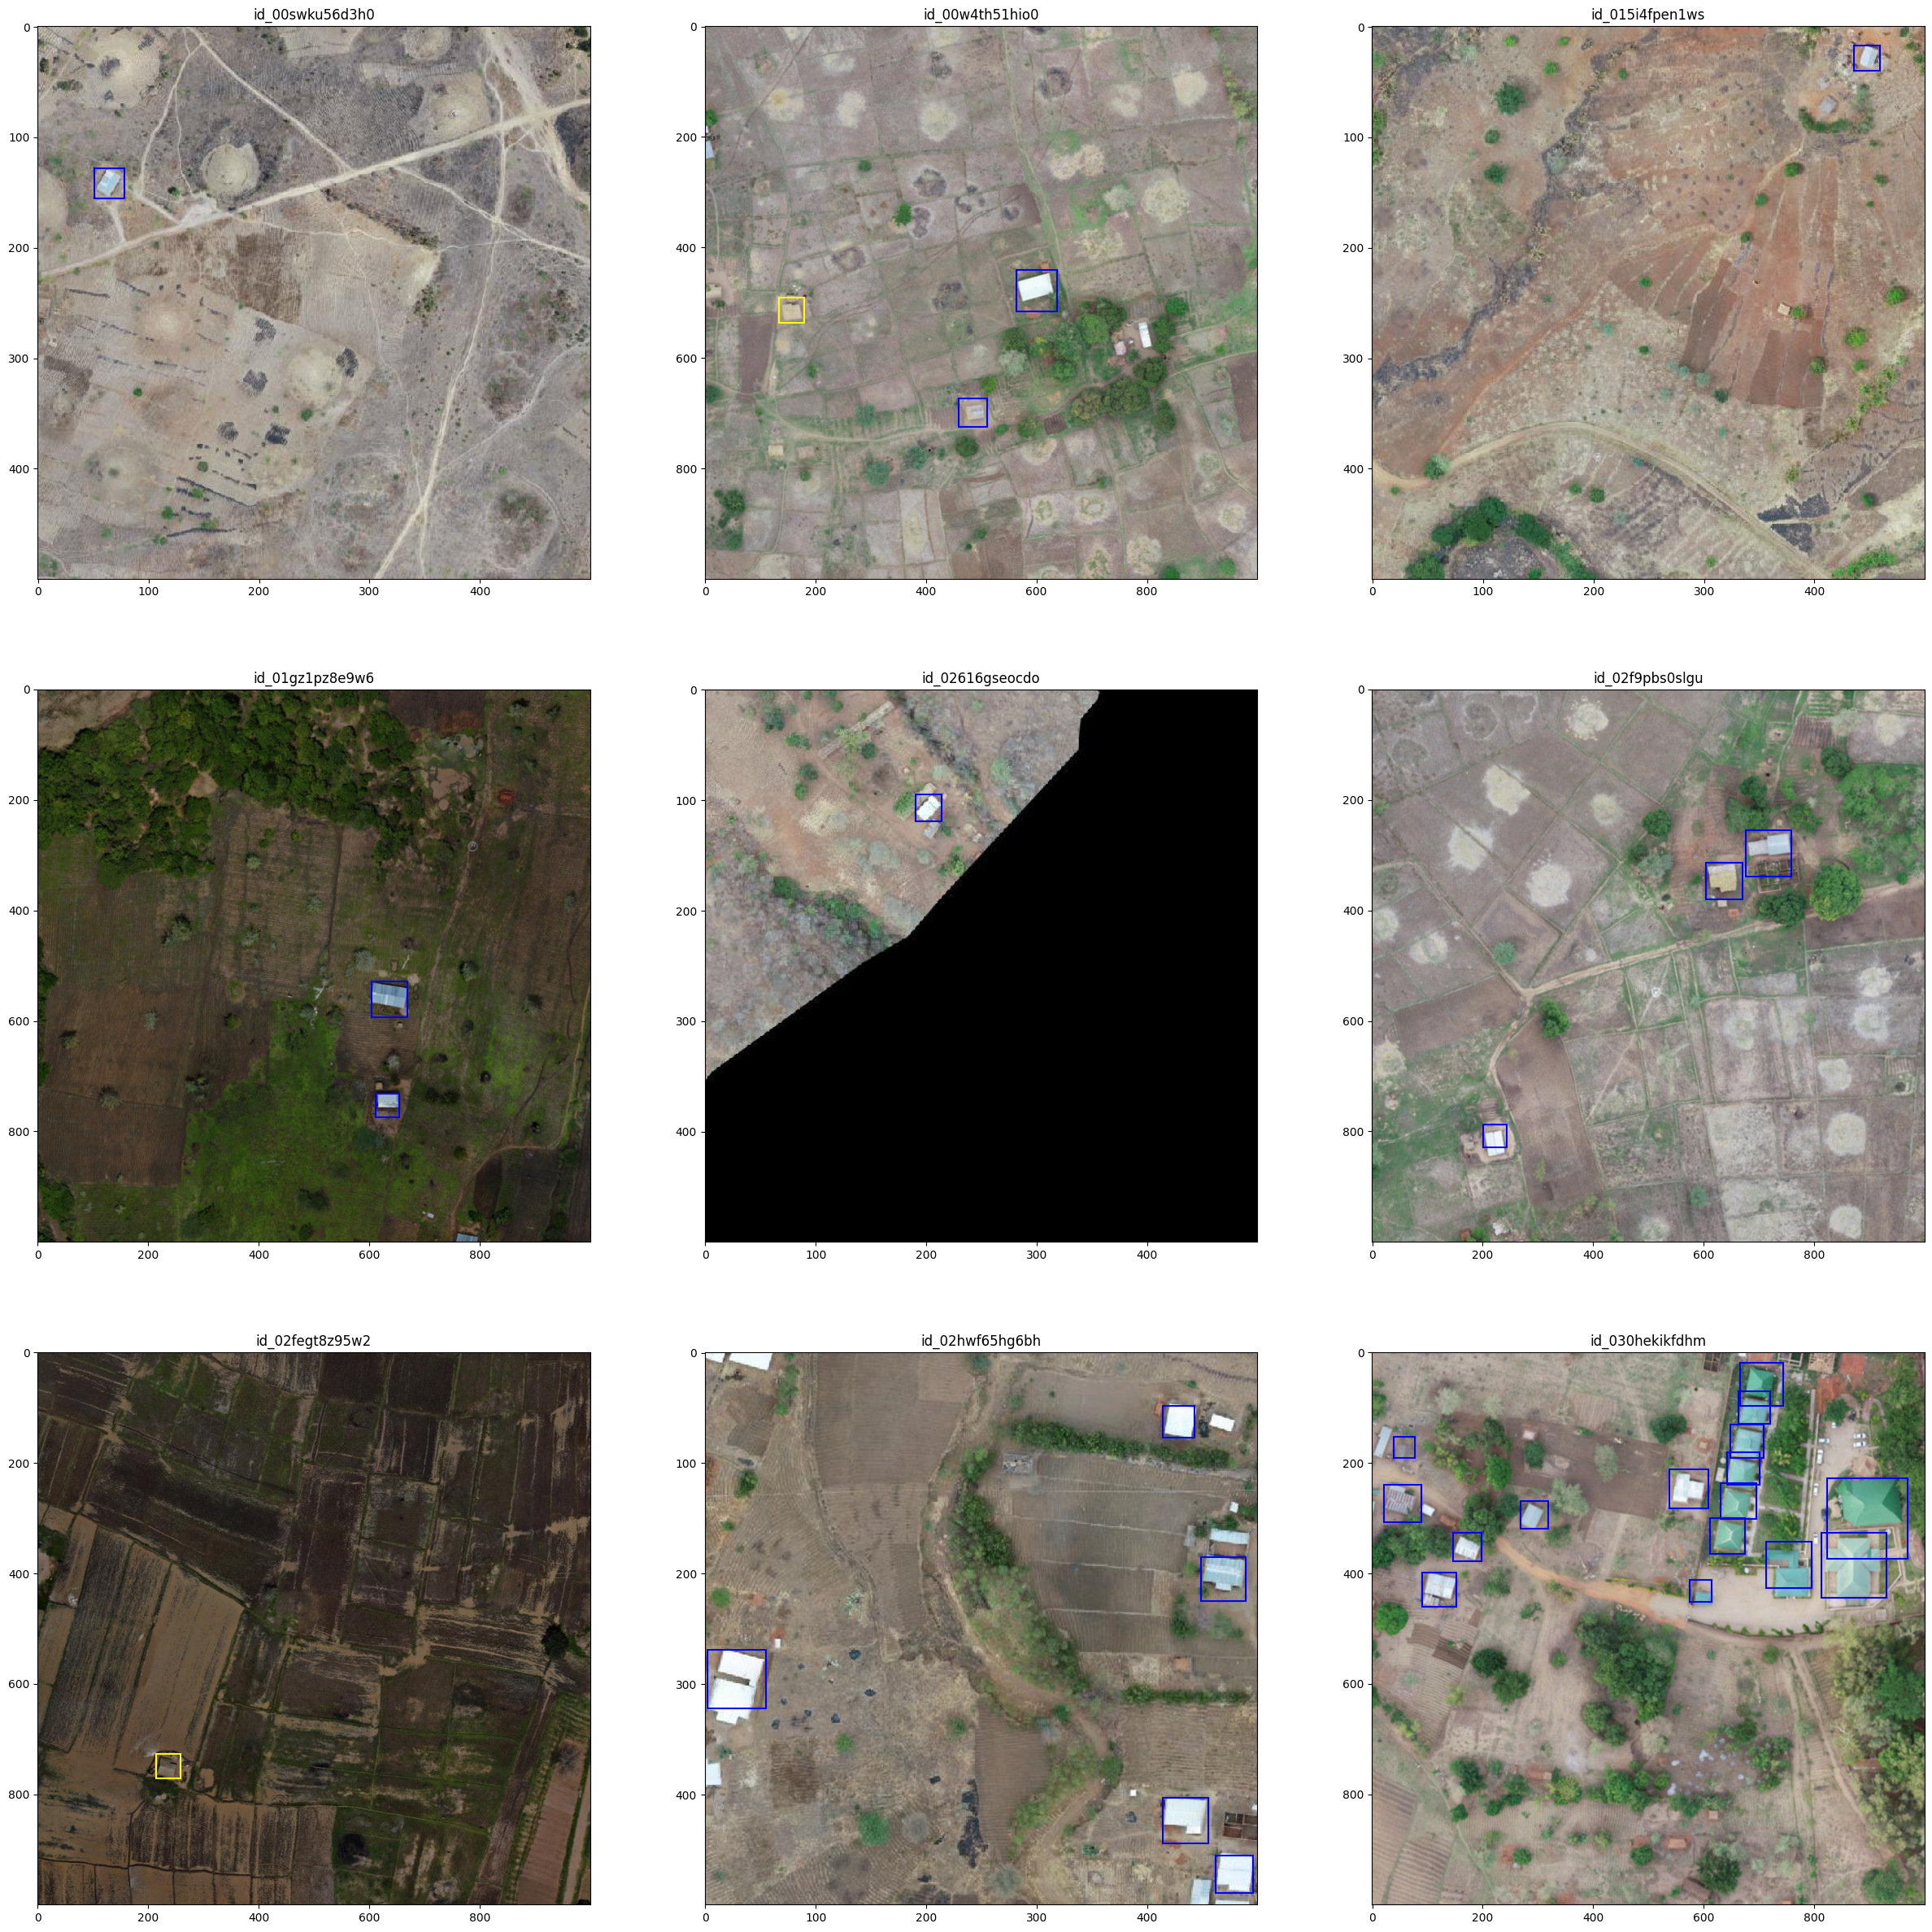

In [23]:
fig, axes = plt.subplots(3, 3, figsize=(30, 30))
colors = {1 : "red", 2 : "blue", 3 : "yellow"}

df = train_df[~train_df.bbox.isna()]
grouped_df = df.groupby('image_id')

images_root = 'Images'

for i, (key, item) in enumerate(grouped_df):
    group = grouped_df.get_group(key)

    file_name = f"{group.iloc[0].image_id}.tif"
    image = rasterio.open(os.path.join(images_root, file_name)).read().transpose((1,2,0))

    axes[i//3, i%3].imshow(image)
    axes[i//3, i%3].set_title(group.iloc[0].image_id)
    for j in range(group.shape[0]):
        bbox = eval(group.iloc[j].bbox)
        category = group.iloc[j].category_id

        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[2], linewidth=1.5, edgecolor=colors[category], facecolor='none')
        axes[i//3, i%3].add_patch(rect)

    if i == 8:
        break

## Get images sizes

In [13]:
def process(file_name):
    path = os.path.join(images_root, f"{file_name}.tif")
    shape = rasterio.open(path).shape
    return shape

file_names = np.unique(pd.concat([train_df, test_df]).image_id)  
with tqdm_joblib(tqdm(desc="Processing", total=file_names.shape[0])) as progress_bar:
    results = Parallel(n_jobs=-1)(delayed(process)(file_name) for file_name in file_names)
# results = np.unique(results, return_counts=True)

Processing:   0%|          | 0/6817 [00:00<?, ?it/s]

In [17]:
np.unique(results, return_counts=True, axis=0)

(array([[ 500,  500],
        [1000, 1000]]),
 array([2454, 4363]))

## Example image

In [25]:
df = train_df[~train_df.bbox.isna()]
grouped_df = df.groupby('image_id')
example_image = grouped_df.get_group("id_02f9pbs0slgu")

In [ ]:
from torchviz import make_dot
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn

model = fasterrcnn_resnet50_fpn()
model.eval()
x = [torch.rand((3, 256, 256))]
predictions = model(x)[0]

make_dot((predictions['boxes'], predictions['scores']), params=dict([('x', x[0]), ('boxes', predictions['boxes']), ('scores', predictions['scores'])]))

In [7]:
targets = [{'boxes' : box, 'labels' : label} for box, label in zip(bboxes, labels)]

In [9]:
images, boxes = torch.rand(4, 3, 600, 1200), torch.rand(4, 11, 4)
boxes[:, :, 2:4] = boxes[:, :, 0:2] + boxes[:, :, 2:4]
labels = torch.randint(1, 91, (4, 11))

In [10]:
images = list(images)
targets = [{'boxes' : box, 'labels' : label} for box, label in zip(boxes, labels)]

In [12]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

model = fasterrcnn_resnet50_fpn()
output = model(images, targets)

In [13]:
output

{'loss_classifier': tensor(4.5167, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0010, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.7023, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(1.3319, grad_fn=<DivBackward0>)}